## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np, pandas as pd
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import matplotlib.pyplot as plt 

import pathlib
from sklearn.metrics import confusion_matrix, classification_report


## Load dataset Metadata

In [2]:
df = pd.read_csv("./BrainDetection/metadata.csv")
print("DF Shape:",df.shape)
print(df.head().to_markdown())


DF Shape: (4600, 6)
|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


## Load Dataset Train and Val

In [3]:
# Dataset Path
data_dir = './BrainDetection/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = './brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:01, 2528.37 files/s]


## Custom Dataset for Train and Val

In [4]:
# Define an object of the custom dataset for the train and validation.

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)
train_set= torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform


Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Defining Hyperparameters

In [5]:
num_epochs = 30 # 20?
num_classes = 2
batch_size = 64
learning_rate = 0.001 # 0.0003


# num_epochs = 10
# learning_rate = 0.00001
# train_CNN = False
# batch_size = 32
# batch_size_validation = 128
# shuffle = True
# pin_memory = True
# num_workers = 1

### Define Dataloader

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [7]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [8]:
# Total number of training images
num_train_images = len(train_loader.dataset)
print(f"Total training images: {num_train_images}")

# Total number of validation images
num_val_images = len(val_loader.dataset)
print(f"Total validation images: {num_val_images}")

Total training images: 3679
Total validation images: 921


## Visualize images

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title, fontsize=14, color='black')  # Set title with desired font size and color

    return ax

training images


TypeError: Axes.imshow() got multiple values for argument 'ax'

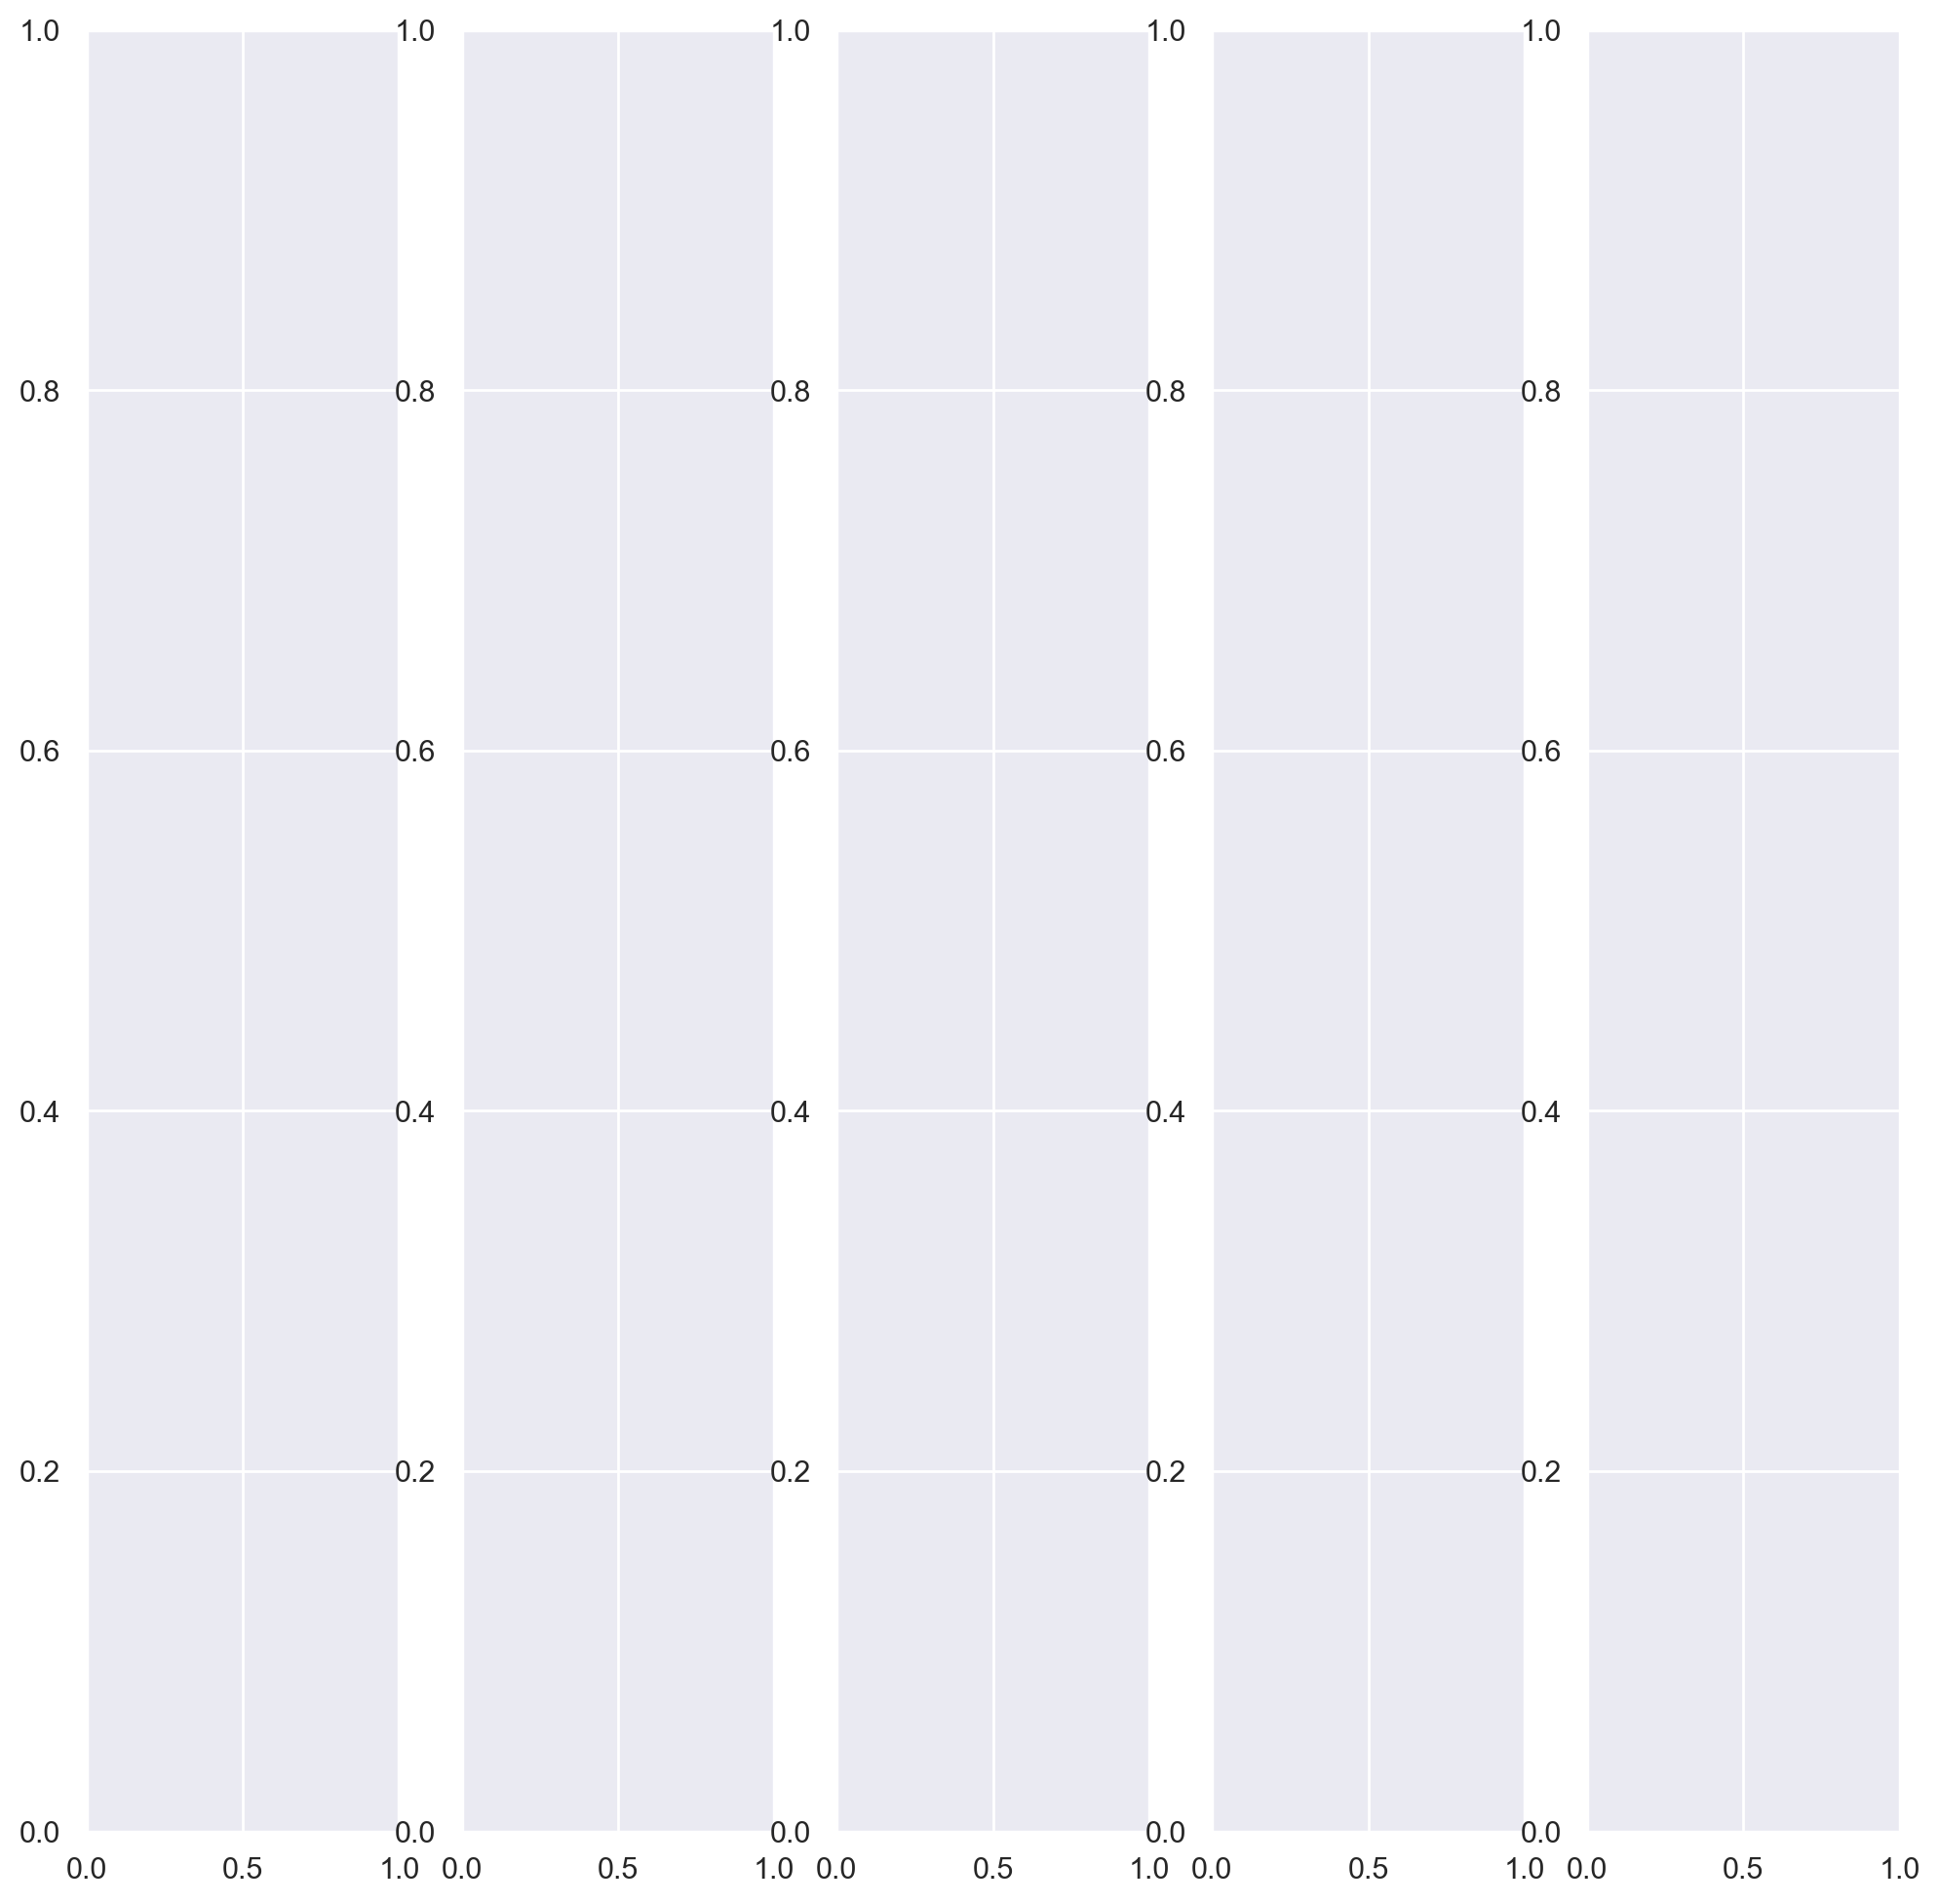

In [69]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    label = "Tumor" if trainlabels[i].item() == 0 else "Healthy"
    imshow(trainimages[i], ax=axe1, title=label, normalize=False)

print(trainimages[0].size())

In [19]:
### Set device to GPU or CPU based on Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

## Define CNN Model 

In [38]:
class CNN(nn.Module): 
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        h,w=findConv2dOutShape(256,256,self.conv1)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        print(h)
        print(w)
        self.num_flatten=h*w*8*8
        self.fc1 = nn.Linear(self.num_flatten, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
        # self.fc1 = None  # Placeholder to be dynamically set
        # self.fc2 = nn.Linear(360, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu((F.max_pool2d(self.conv3(x), 2)))
        x = F.relu((F.max_pool2d(self.conv4(x), 2)))
        
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 360).to(x.device)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.25)
        x = self.fc2(x)
        return x
        #check:
        # return F.log_softmax(X, dim=1)


In [39]:
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

14
14


In [40]:
# Model Summary for CNN Model
summary(model, input_size=(3, 256, 256),device=device.type)

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


## Training Model

In [41]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)

    # validate-the-model
    model.eval()
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

hola
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Epoch: 1 	Training Loss: 0.579077 	Validation Loss: 0.472669
hola
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Epoch: 2 	Training Loss: 0.464928 	Validation Loss: 0.457287
hola
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

## Test Model

In [42]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Test Accuracy of the model: 98.0456026058632 %


In [47]:
train_loss

0.041037125317022895

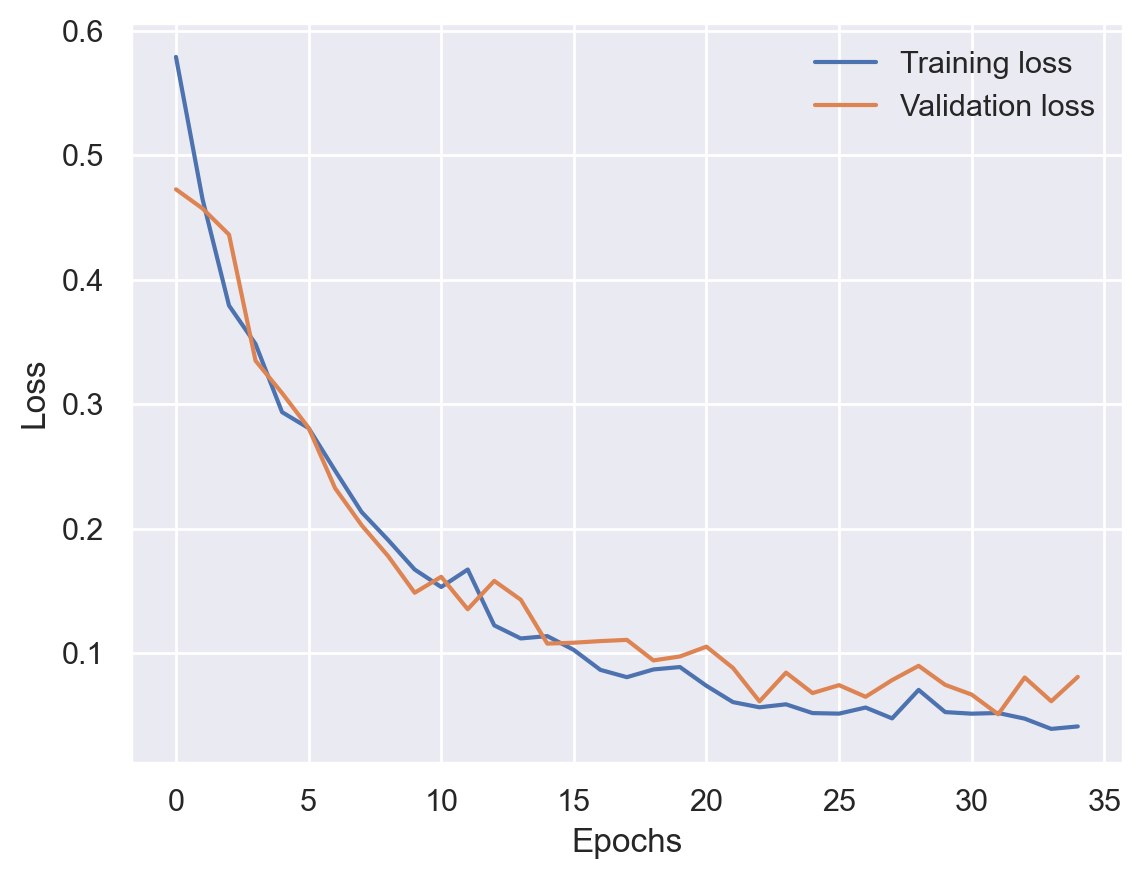

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [50]:
torch.save(model, "Brain_Tumor_model.pt")

## Prediction

In [54]:
model.eval()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

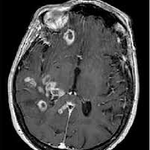

In [60]:
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
from IPython.display import display


data = np.ndarray(shape=(1,150, 150, 1), dtype=np.float32)
data_dir = './BrainDetection/Brain Tumor Data Set/Brain Tumor Data Set'

image = Image.open('./BrainDetection/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg')
size = (150, 150)
image = ImageOps.grayscale(image)
image = ImageOps.fit(image, size, Image.LANCZOS)
image_array = np.asarray(image)
display(image)
#normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
data = image_array.reshape((-1,150,150,1))
#data[0] = normalized_image_array

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using training stats
])
image2 = Image.open('./BrainDetection/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg')
image2 = transform(image2)  # Apply transformations
image2 = image2.unsqueeze(0)  # Add batch dimension (1, 3, 256, 256)



In [68]:
# Move the image and model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image2.to(device)
model2 = model.to(device)

# Get predictions
with torch.no_grad():  # Disable gradient computation
    output = model2(image)  # Forward pass
    probabilities = torch.softmax(output, dim=1)  # Get probabilities for each class
    predicted_class = torch.argmax(probabilities, dim=1)  # Get the class index with highest probability

# Print results
print(f"Predicted class index: {'Tumor' if predicted_class.item() == 0 else 'Healthy'}")
print(f"Probabilities: {probabilities.cpu().numpy()}")

False
Predicted class index: Tumor
Probabilities: [[0.9981962  0.00180387]]
